In [169]:
import os
import sys; sys.path.append("~/HHbbgg_ETH_devel/Training/python") # to load packages
import training_utils as utils
import numpy as np
reload(utils)
import preprocessing_utils as preprocessing
reload(preprocessing)
import plotting_utils as plotting
reload(plotting)
import optimization_utils as optimization
reload(optimization)
import postprocessing_utils as postprocessing
reload(postprocessing)
import pandas as pd
import root_pandas as rpd
import matplotlib.pyplot as plt
import json
from ROOT import TLorentzVector
from optparse import OptionParser, make_option
from  pprint import pprint
import commands
import time
import datetime
start_time = time.time()

In [159]:
clf_trainings = []
plot_classifier_all = []
fpr_dipho_all,tpr_dipho_all = [],[]
fpr_gJets_all,tpr_gJets_all = [],[]
X_total_train_all = []
X_total_test_all = []
y_total_train_all = []
y_total_test_all = []
labels=[]

In [170]:
year=0

dirs = ['ntuples_2016_20191803','ntuples_2017_20191803']
ntuples = dirs[year]
SMname = ['GluGluToHHTo2B2G_nodesPlusSM_13TeV_madgraph_13TeV_DoubleHTag_0','GluGluToHHTo2B2G_nodesPlusSM_13TeV_madgraph_13TeV_DoubleHTag_0']
NodesNormalizationFile = '/shome/nchernya/HHbbgg_ETH_devel/root_files/normalizations/reweighting_normalization_18_03_2019.json'
useMixOfNodes = True
whichNodes = list(np.arange(0,12,1))
whichNodes.append('SM')
signalMixOfNodesNormalizations = json.loads(open(NodesNormalizationFile).read())
# "%" sign allows to interpret the rest as a system command
get_ipython().magic(u'env data=$utils.IO.ldata$ntuples')
status,files = commands.getstatusoutput('! ls $data | sort -t_ -k 3 -n')
files=files.split('\n')    
    
signal = [s for s in files if ("GluGluToHHTo2B2G_nodesPlusSM_" in s) ]
diphotonJets = [s for s in files if "DiPhotonJetsBox_" in s]
#diphotonJets_1B = [s for s in files if "DiPhotonJetsBox1B" in s] # will use for limits
#diphotonJets_2B = [s for s in files if "DiPhotonJetsBox2B" in s] # will use for limits
gJets_lowPt = [s for s in files if "GJet_Pt-20to40" in s]
gJets_highPt = [s for s in files if "GJet_Pt-40" in s]

utils.IO.use_signal_nodes(useMixOfNodes,whichNodes,signalMixOfNodesNormalizations)
utils.IO.add_signal(ntuples,signal,1,'tagsDumper/trees/%s'%SMname[year],year)
#utils.IO.add_signal(ntuples,signal,1,'GluGluToHHTo2B2G_12nodes_13TeV_madgraph',year)
utils.IO.add_background(ntuples,diphotonJets,-1,'tagsDumper/trees/'+diphotonJets[0][diphotonJets[0].find('output_')+7:diphotonJets[0].find('.root')].replace('-','_')+'_13TeV_DoubleHTag_0',year)
utils.IO.add_background(ntuples,gJets_lowPt,-2,'tagsDumper/trees/'+gJets_lowPt[0][gJets_lowPt[0].find('output_')+7:gJets_lowPt[0].find('.root')].replace('-','_')+'_13TeV_DoubleHTag_0',year)                            
utils.IO.add_background(ntuples,gJets_highPt,-2,'tagsDumper/trees/'+gJets_highPt[0][gJets_highPt[0].find('output_')+7:gJets_highPt[0].find('.root')].replace('-','_')+'_13TeV_DoubleHTag_0',year)                           

for i in range(len(utils.IO.backgroundName)):        
    print "using background file n."+str(i)+": "+utils.IO.backgroundName[i]
for i in range(len(utils.IO.signalName)):    
    print "using signal file n."+str(i)+": "+utils.IO.signalName[i]

env: data=/shome/nchernya/HHbbgg_ETH_devel/root_files/ntuples_2016_20191803
using background file n.0: /shome/nchernya/HHbbgg_ETH_devel/root_files/ntuples_2016_20191803/output_DiPhotonJetsBox_MGG-80toInf_13TeV-Sherpa.root
using background file n.1: /shome/nchernya/HHbbgg_ETH_devel/root_files/ntuples_2016_20191803/output_GJet_Pt-20to40_DoubleEMEnriched_MGG-80toInf_TuneCUETP8M1_13TeV_Pythia8.root
using background file n.2: /shome/nchernya/HHbbgg_ETH_devel/root_files/ntuples_2016_20191803/output_GJet_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCUETP8M1_13TeV_Pythia8.root
using signal file n.0: /shome/nchernya/HHbbgg_ETH_devel/root_files/ntuples_2016_20191803/output_GluGluToHHTo2B2G_nodesPlusSM_13TeV-madgraph.root


In [171]:
outstr = "23_05_2019_trainingMjj_year_nosmear%s"%year
utils.IO.plotFolder = '/mnt/t3nfs01/data01/shome/nchernya/HHbbgg_ETH_devel/Training/plots/%s/'%outstr
if not os.path.exists(utils.IO.plotFolder):
    print utils.IO.plotFolder, "doesn't exist, creating it..."
    os.makedirs(utils.IO.plotFolder)

doReweight2017 = False #reweight signal from 2017 to match 2016 (mix of nodes reweight with HH_mass at gen level)

In [172]:
#use noexpand for root expressions, it needs this file https://github.com/ibab/root_pandas/blob/master/root_pandas/readwrite.py
########################new code branches############################
#branch_names = 'leadingJet_bDis,subleadingJet_bDis,absCosThetaStar_CS,absCosTheta_bb,absCosTheta_gg,diphotonCandidatePtOverdiHiggsM,dijetCandidatePtOverdiHiggsM,customLeadingPhotonIDMVA,customSubLeadingPhotonIDMVA,leadingPhotonSigOverE,subleadingPhotonSigOverE,sigmaMOverMDecorr,PhoJetMinDr'.split(",") #set of variables March 2017 but regressed
branch_names = 'Mjj,leadingJet_DeepCSV,subleadingJet_DeepCSV,absCosThetaStar_CS,absCosTheta_bb,absCosTheta_gg,diphotonCandidatePtOverdiHiggsM,dijetCandidatePtOverdiHiggsM,customLeadingPhotonIDMVA,customSubLeadingPhotonIDMVA,leadingPhotonSigOverE,subleadingPhotonSigOverE,sigmaMOverM,PhoJetMinDr'.split(",") #set of variables March 2017 but regressed
b_reg_branches = 'noexpand:(leadingJet_bRegNNResolution*1.4826),noexpand:(subleadingJet_bRegNNResolution*1.4826),noexpand:(sigmaMJets*1.4826)'.split(",")
branch_cuts = 'leadingJet_pt,subleadingJet_pt,leadingJet_bRegNNCorr,subleadingJet_bRegNNCorr,noexpand:(leadingJet_pt/leadingJet_bRegNNCorr),noexpand:(subleadingJet_pt/subleadingJet_bRegNNCorr)'.split(',')
cuts = 'leadingJet_pt>0'
nodesWeightBranches=[]
if utils.IO.signalMixOfNodes : nodesWeightBranches=[ 'benchmark_reweight_%s'%i for i in whichNodes ] 
#cuts = 'subleadingJet_pt>25'
######################

#event_branches = ['event','sigmaMOverM','noexpand:(dijetSigmaMOverM*1.4826)']
event_branches = ['event','weight','MX','leadingJet_hflav','leadingJet_pflav','subleadingJet_hflav','subleadingJet_pflav']

branch_names = branch_names + ['rho']
branch_names = branch_names+b_reg_branches
resolution_weighting = 'ggbb' # None, gg or ggbb
doOverlapRemoval=False   #diphotons overlap removal if using b-enriched samples


branch_names = [c.strip() for c in branch_names]
print branch_names

event_bkg,event_sig = None,None
if (year==1 and doReweight2017 == True):
    preprocessing.set_signals(branch_names+event_branches+branch_cuts+['genMhh'],True,cuts)
    preprocessing.set_backgrounds(branch_names+event_branches+branch_cuts,True,cuts)
else :
    preprocessing.set_signals(branch_names+event_branches+branch_cuts+nodesWeightBranches,True,cuts)
    preprocessing.set_backgrounds(branch_names+event_branches+branch_cuts,True,cuts)


info_file = open(utils.IO.plotFolder+"info_%s.txt"%outstr,"w") 
info_file.write("\n".join(branch_names))
info_file.write("Resolution weighting : %s\n"%resolution_weighting)
info_file.write("Cuts : %s\n"%cuts)
info_file.write("Signal weighted Events Sum before inverse resolution weighting : \n")
info_file.write("%.4f \n"%(np.sum(utils.IO.signal_df[0]['weight']))) 
info_file.write("Background weighted Events Sum : \n")
sum_bkg_weights = 0
for bkg_type in range(utils.IO.nBkg):
    bkg_weight = np.sum(utils.IO.background_df[bkg_type]['weight'])
    sum_bkg_weights+=bkg_weight
    info_file.write("proc %d : %.4f \n"%( utils.IO.bkgProc[bkg_type],bkg_weight)) 
info_file.write("Background weighted Events Sum Total : %.4f \n"%(sum_bkg_weights)) 
info_file.close()


####Change the scale of Mjj for a test, Mjj -> 1.1Mjj#########
#for bkg_type in range(utils.IO.nBkg):
#    utils.IO.background_df[bkg_type]['Mjj'] = utils.IO.background_df[bkg_type]['Mjj'].apply(lambda x: x* np.random.normal(1,0.1))
#for sig_type in range(utils.IO.nSig):
#    utils.IO.signal_df[0]['Mjj'] = utils.IO.signal_df[0]['Mjj'].apply(lambda x: x* np.random.normal(1,0.1))
#################################


if 'gg' in resolution_weighting : 
    preprocessing.weight_signal_with_resolution_all(branch='sigmaMOverM')
if 'bb' in resolution_weighting : 
    preprocessing.weight_signal_with_resolution_all(branch='(sigmaMJets*1.4826)')

if doOverlapRemoval == True:    
    for i in range(utils.IO.nBkg):
        if 'DiPhotonJetsBox_MGG' in utils.IO.bkgTreeName[i] : preprocessing.cleanOverlapDiphotons(utils.IO.bkgTreeName[i],utils.IO.background_df[i])        

if (year==1 and doReweight2017 == True):
    preprocessing.reweight_gen_mhh('mhh',genFrame2016,genFrame2017,utils.IO.signal_df[0],'genMhh')


X_bkg,y_bkg,weights_bkg,event_bkg,X_sig,y_sig,weights_sig,event_sig=preprocessing.set_variables(branch_names,use_event_num=True)




X_bkg,y_bkg,weights_bkg,event_bkg = preprocessing.randomize(X_bkg,y_bkg,weights_bkg,event_num = np.asarray(event_bkg))
X_sig,y_sig,weights_sig,event_sig = preprocessing.randomize(X_sig,y_sig,weights_sig,event_num = np.asarray(event_sig))


#Get training and test samples based on event number : even/odd or %5, set in the function for now
y_total_train = preprocessing.get_total_training_sample_event_num(y_sig.reshape(-1,1),y_bkg,event_sig.reshape(-1,1),event_bkg).ravel()
X_total_train = preprocessing.get_total_training_sample_event_num(X_sig,X_bkg,event_sig.reshape(-1,),event_bkg.reshape(-1,))

y_total_test = preprocessing.get_total_test_sample_event_num(y_sig.reshape(-1,1),y_bkg,event_sig.reshape(-1,1),event_bkg).ravel()
X_total_test = preprocessing.get_total_test_sample_event_num(X_sig,X_bkg,event_sig.reshape(-1,),event_bkg.reshape(-1,))

w_total_train = preprocessing.get_total_training_sample_event_num(weights_sig.reshape(-1,1),weights_bkg.reshape(-1,1),event_sig.reshape(-1,1),event_bkg).ravel()
w_total_test = preprocessing.get_total_test_sample_event_num(weights_sig.reshape(-1,1),weights_bkg.reshape(-1,1),event_sig.reshape(-1,1),event_bkg).ravel()


##########Normalize weights for training and testing. Sum(signal)=Sum(bkg)=1. But keep relative normalization
# between bkg classes
w_total_train = preprocessing.normalize_process_weights_split_all(w_total_train,y_total_train)
w_total_test = preprocessing.normalize_process_weights_split_all(w_total_test,y_total_test)


X_total_train_all.append(X_total_train)
X_total_test_all.append(X_total_test)
y_total_train_all.append(y_total_train)
y_total_test_all.append(y_total_test)

['Mjj', 'leadingJet_DeepCSV', 'subleadingJet_DeepCSV', 'absCosThetaStar_CS', 'absCosTheta_bb', 'absCosTheta_gg', 'diphotonCandidatePtOverdiHiggsM', 'dijetCandidatePtOverdiHiggsM', 'customLeadingPhotonIDMVA', 'customSubLeadingPhotonIDMVA', 'leadingPhotonSigOverE', 'subleadingPhotonSigOverE', 'sigmaMOverM', 'PhoJetMinDr', 'rho', 'noexpand:(leadingJet_bRegNNResolution*1.4826)', 'noexpand:(subleadingJet_bRegNNResolution*1.4826)', 'noexpand:(sigmaMJets*1.4826)']
using tree:tagsDumper/trees/GluGluToHHTo2B2G_nodesPlusSM_13TeV_madgraph_13TeV_DoubleHTag_0
using tree:tagsDumper/trees/DiPhotonJetsBox_MGG_80toInf_13TeV_Sherpa_13TeV_DoubleHTag_0
using tree:tagsDumper/trees/GJet_Pt_20to40_DoubleEMEnriched_MGG_80toInf_TuneCUETP8M1_13TeV_Pythia8_13TeV_DoubleHTag_0
using tree:tagsDumper/trees/GJet_Pt_40toInf_DoubleEMEnriched_MGG_80toInf_TuneCUETP8M1_13TeV_Pythia8_13TeV_DoubleHTag_0


In [163]:
print "Starting the training now : "
now = str(datetime.datetime.now())
print(now)

################Training a classifier###############
########final optimization with all fixed#######
from sklearn.externals import joblib
import xgboost as xgb
n_threads=20

#optimized parameters with Mjj for 2016 done by Francesco
#clf = xgb.XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
#       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=15,
#       min_child_weight=1e-06,  n_estimators=2000,
#       nthread=n_threads, objective='multi:softprob', reg_alpha=0.0,
#       reg_lambda=0.05, scale_pos_weight=1, seed=None, silent=True,
#       subsample=1)
clf = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
   colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
   max_depth=3, min_child_weight=0.0001, 
   n_estimators=1000, n_jobs=1, nthread=n_threads, objective='binary:logistic',
   random_state=0, reg_alpha=0.0, reg_lambda=0.05, scale_pos_weight=1,
   seed=0, silent=True, subsample=1)

clf.fit(X_total_train,y_total_train, sample_weight=w_total_train)


print 'Training is done. It took', time.time()-start_time, 'seconds.'

joblib.dump(clf, os.path.expanduser('/shome/nchernya/HHbbgg_ETH_devel/Training/output_files/training_with_%s.pkl'%outstr), compress=9)

clf_trainings.append(clf)

Starting the training now : 
2019-05-23 14:36:13.683660
Training is done. It took 319.513062 seconds.


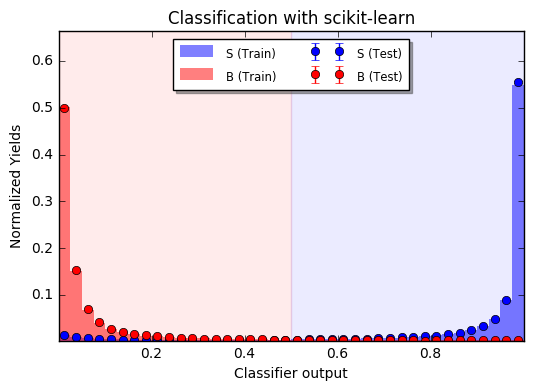

In [179]:
plot_classifier = plotting.plot_classifier_output(clf,X_total_test_all[0],X_total_test_all[1],y_total_test_all[0],y_total_test_all[1],outString=outstr)
plt.show()
#fpr_dipho,tpr_dipho = plotting.plot_roc_curve_multiclass_singleBkg(X_total_test,y_total_test,clf,-1,outString=outstr,weights=w_total_test)
#fpr_gJets,tpr_gJets = plotting.plot_roc_curve_multiclass_singleBkg(X_total_test,y_total_test,clf,-2,outString=outstr,weights=w_total_test)

#roc_df_dipho = pd.DataFrame({"fpr_dipho": (fpr_dipho).tolist(),"tpr_dipho": (tpr_dipho).tolist()})
#roc_df_gJets = pd.DataFrame({"fpr_gJets": (fpr_gJets).tolist(),"tpr_gJets": (tpr_gJets).tolist()})
#roc_df_dipho.to_hdf(utils.IO.plotFolder+"roc_curves_dipho_%s.h5"%outstr, key='df', mode='w')
#roc_df_gJets.to_hdf(utils.IO.plotFolder+"roc_curves_gJets_%s.h5"%outstr, key='df', mode='w')

In [154]:
#utils.IO.signal_df[0]['Mjjnew'] = utils.IO.signal_df[0]['Mjj'].apply(lambda x: x * np.random.uniform(0.8,1.2))
#utils.IO.signal_df[0]['Mjjnew2'] = utils.IO.signal_df[0]['Mjj'].apply(lambda x: x*(1+((x-125.)/125.) * np.random.normal(1,0.2)))
utils.IO.signal_df[0]['Mjjnew2'] = utils.IO.signal_df[0]['Mjj'].apply(lambda x: x* np.random.normal(1,0.1))

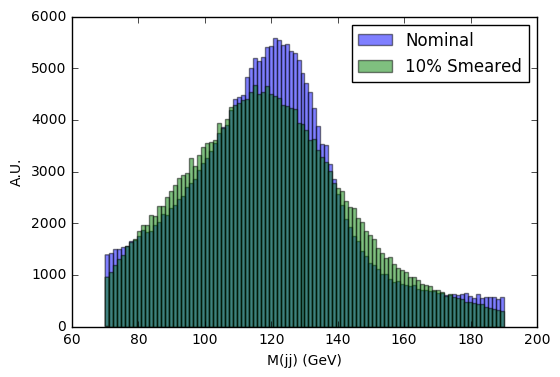

In [155]:
_,bins,_=plt.hist(utils.IO.signal_df[0]['Mjj'],bins=100,label='Nominal',alpha=0.5)
plt.hist(utils.IO.signal_df[0]['Mjjnew2'],bins=bins,label='10% Smeared',alpha=0.5)
plt.legend()
plt.xlabel('M(jj) (GeV)')
plt.ylabel('A.U.')
plt.show()